# Introduction

In this notebook, we provide code for the experiments conducted in the project. For clarity, all the experiments here are done for the dataset of sequences of MNIST imeges. The same experiments may be repeated for any other dataset (Synthetic1D, Human Activity Recognition, Explosion). Moreover, they can repeated be for any other dataset or model presented in the source paper: "InDiD: Instant Disorder Detection via a Principled Neural Network".

In [12]:
# necessary imports
from utils import metrics
from utils.ensembles import EnsembleCPDModel, CusumEnsembleCPDModel

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from datetime import datetime
from typing import Any

import yaml

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ensemble model, MNIST dataset

## Initialize and train the model

In [2]:
model_type = "seq2seq"

# choose any dataset you need, i.e. "synthetic_1D", "human_activity", "mnist" or "explosion"
experiments_name = "mnist"

# read arguments from a default config file for a particular experiment
path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

# update args dictionary for con
args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

# choose loss type - 'BCE' in our case
args_config["loss_type"] = "bce"

# number of CPUs available
args_config["num_workers"] = 2

# set args_config["learning"]["gpus"] = 0 for training models on CPU
args_config["learning"]["gpus"] = 1

# number of epochs to train each model in ensemble
args_config["learning"]["epochs"] = 100

In [3]:
# Initialize Ensemble of n_models=10 base models
# boot_sample_size=None indicates training on the full train set
# Otherwise, choose int boot_sample_size to train models on bootstrapped subsamples of the train set
ens_mnist_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)

# fit the models and save the models weights
ens_mnist_bce.fit()
ens_mnist_bce.save_models_list("saved_models/mnist")

# OR load weights of the pre-trained models available
#ens_mnist_bce.load_models_list("saved_models/mnist")

## Visialize random predictions

In [4]:
def visualize_predictions(
        model: Any,
        sequences_batch: torch.Tensor,
        labels_batch: torch.Tensor,
        n_pics: int = 10,
        save: bool = False
) -> None:
    """Visualize model's predictions for a batch of test sequences.
    
    :param model: trained model (e.g. CPDModel or EnsembleCPDModel)
    :param sequences_batch: batch of test sequences
    :param lavels_batch: batch of corresponding labels
    :param n_pics: number of pictures to plot
    :param save: if True, save pictures to the 'pictures' folder    
    """
    model.to("cpu")
    sequences_batch = sequences_batch.cpu()
    labels_batch = labels_batch.cpu()

    if len(sequences_batch) < n_pics:
        print("Desired number of pictures is greater than size of the batch provided.")
        n_pics = len(sequences_batch) 
    
    try:
        preds = model(sequences_batch)
    except:
        preds, std = model.predict(sequences_batch)
        std = std.detach().cpu().squeeze()
    
    preds = preds.detach().cpu().squeeze()
    
    for idx in range(n_pics):    
        plt.figure()
        plt.plot(preds[idx], label="Predictions")
        plt.fill_between(range(len(preds[idx])), preds[idx] - std[idx], preds[idx] + std[idx], alpha=0.3)
        plt.plot(labels_batch[idx], label="Labels")
        plt.title("Mean +- std redictions", fontsize=14)
        plt.legend(fontsize=12)
        if save:
            plt.savefig("pictures/preds_seq_{}.pdf".format(idx))
        plt.show()
        

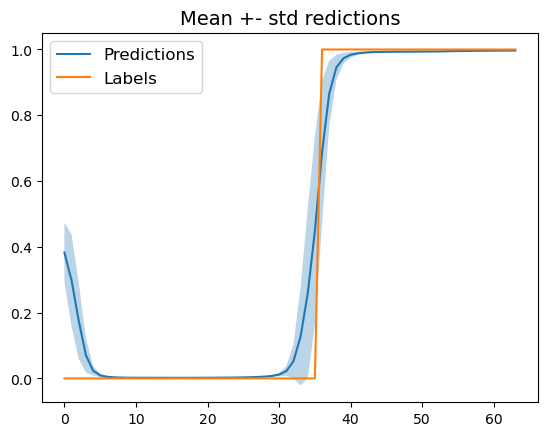

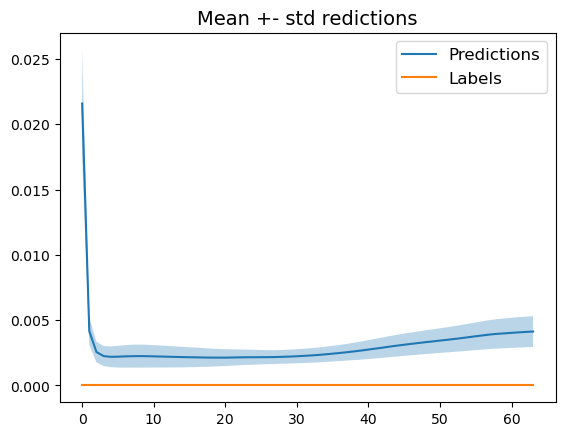

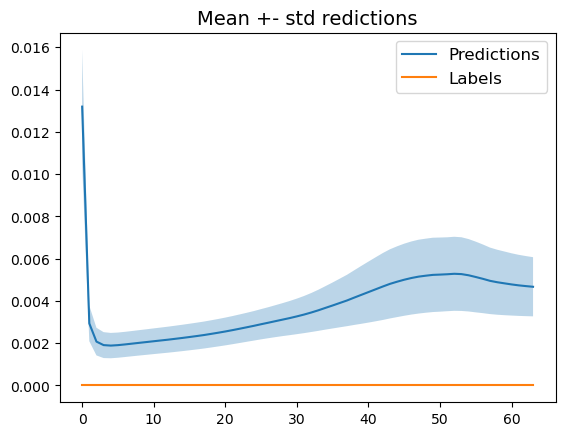

In [5]:
# create test_dataset and test_dataloader

test_dataset = ens_mnist_bce.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size = args_config["learning"]["batch_size"], shuffle=True)

seq_batch, labels_batch = next(iter(test_dataloader))

visualize_predictions(ens_mnist_bce, seq_batch, labels_batch, n_pics=3)

## Compute metrics for the ensemble mean predictions

In [6]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

seed = 0

# compute metrics
metrics_local, delay_list, fp_delay_list = \
    metrics.evaluation_pipeline(ens_mnist_bce,
                                test_dataloader,
                                threshold_list,
                                device="cuda", # choose 'cpu' or 'cuda' if available
                                model_type="ensemble",
                                verbose=True
                                )

# if necessary, write metrics to file
'''
metrics.write_metrics_to_file(
    filename="results/results_" + experiments_name + "_" + model_type + "_10_models.txt",
    metrics=metrics_local,
    seed=seed,
    timestamp=datetime.now().strftime("%y%m%dT%H%M%S"),
    comment="MNIST, ensemble mean predictions"
)
'''

  1%|▋                                                                     | 1/102 [00:05<09:10,  5.45s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.7872509765625


  2%|█▎                                                                    | 2/102 [00:10<08:55,  5.35s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.7872509765625


  3%|██                                                                    | 3/102 [00:16<08:50,  5.36s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.7872509765625


  4%|██▋                                                                   | 4/102 [00:21<08:42,  5.33s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.09333333373069763, COVER: 0.7881508608217592


  5%|███▍                                                                  | 5/102 [00:26<08:32,  5.28s/it]

TN: 2, FP: 297, FN: 0, TP: 1, DELAY:0.0, FP_DELAY:0.7766666412353516, COVER: 0.7910839242788461


  6%|████                                                                  | 6/102 [00:31<08:24,  5.25s/it]

TN: 3, FP: 296, FN: 0, TP: 1, DELAY:0.0, FP_DELAY:0.9933333396911621, COVER: 0.79115388601354


  7%|████▊                                                                 | 7/102 [00:37<08:26,  5.33s/it]

TN: 8, FP: 291, FN: 0, TP: 1, DELAY:0.0, FP_DELAY:2.109999895095825, COVER: 0.7920919174761251


  8%|█████▍                                                                | 8/102 [00:42<08:12,  5.24s/it]

TN: 9, FP: 288, FN: 0, TP: 3, DELAY:0.0, FP_DELAY:2.7033333778381348, COVER: 0.7966680864793741


  9%|██████▏                                                               | 9/102 [00:47<08:12,  5.30s/it]

TN: 14, FP: 283, FN: 0, TP: 3, DELAY:0.0, FP_DELAY:4.043333530426025, COVER: 0.7993730277905207


 10%|██████▊                                                              | 10/102 [00:52<07:59,  5.21s/it]

TN: 18, FP: 279, FN: 0, TP: 3, DELAY:0.0, FP_DELAY:5.199999809265137, COVER: 0.7994800953571306


 11%|███████▍                                                             | 11/102 [00:57<07:49,  5.16s/it]

TN: 25, FP: 272, FN: 0, TP: 3, DELAY:0.0, FP_DELAY:7.119999885559082, COVER: 0.8051314064162514


 12%|████████                                                             | 12/102 [01:03<07:50,  5.22s/it]

TN: 32, FP: 265, FN: 0, TP: 3, DELAY:0.0, FP_DELAY:9.029999732971191, COVER: 0.8106555297171051


 13%|████████▊                                                            | 13/102 [01:08<07:43,  5.21s/it]

TN: 46, FP: 250, FN: 0, TP: 4, DELAY:0.0, FP_DELAY:12.84333324432373, COVER: 0.8232285456908534


 14%|█████████▍                                                           | 14/102 [01:13<07:44,  5.28s/it]

TN: 58, FP: 235, FN: 0, TP: 7, DELAY:0.0, FP_DELAY:15.853333473205566, COVER: 0.8311669980415705


 15%|██████████▏                                                          | 15/102 [01:18<07:32,  5.21s/it]

TN: 66, FP: 227, FN: 0, TP: 7, DELAY:0.0, FP_DELAY:18.0766658782959, COVER: 0.8378875708205513


 16%|██████████▊                                                          | 16/102 [01:23<07:24,  5.17s/it]

TN: 77, FP: 208, FN: 0, TP: 15, DELAY:0.0033333334140479565, FP_DELAY:21.34666633605957, COVER: 0.8514781857505773


 17%|███████████▌                                                         | 17/102 [01:29<07:19,  5.17s/it]

TN: 80, FP: 205, FN: 0, TP: 15, DELAY:0.0033333334140479565, FP_DELAY:22.706666946411133, COVER: 0.8609546992566974


 18%|████████████▏                                                        | 18/102 [01:34<07:14,  5.18s/it]

TN: 90, FP: 193, FN: 0, TP: 17, DELAY:0.006666666828095913, FP_DELAY:25.343334197998047, COVER: 0.8694638845152776


 19%|████████████▊                                                        | 19/102 [01:39<07:06,  5.14s/it]

TN: 98, FP: 180, FN: 0, TP: 22, DELAY:0.006666666828095913, FP_DELAY:27.823333740234375, COVER: 0.8813473825540822


 20%|█████████████▌                                                       | 20/102 [01:44<07:03,  5.16s/it]

TN: 104, FP: 172, FN: 0, TP: 24, DELAY:0.029999999329447746, FP_DELAY:30.02666664123535, COVER: 0.8962073066336461


 21%|██████████████▏                                                      | 21/102 [01:49<06:56,  5.15s/it]

TN: 110, FP: 163, FN: 0, TP: 27, DELAY:0.046666666865348816, FP_DELAY:31.72333335876465, COVER: 0.904052500962386


 22%|██████████████▉                                                      | 22/102 [01:54<06:54,  5.18s/it]

TN: 117, FP: 153, FN: 0, TP: 30, DELAY:0.05666666850447655, FP_DELAY:33.6966667175293, COVER: 0.9114261095545437


 23%|███████████████▌                                                     | 23/102 [02:00<06:49,  5.18s/it]

TN: 123, FP: 143, FN: 0, TP: 34, DELAY:0.05999999865889549, FP_DELAY:35.59000015258789, COVER: 0.9194350592460925


 24%|████████████████▏                                                    | 24/102 [02:05<06:45,  5.19s/it]

TN: 128, FP: 135, FN: 0, TP: 37, DELAY:0.10333333164453506, FP_DELAY:37.143333435058594, COVER: 0.9249974361213045


 25%|████████████████▉                                                    | 25/102 [02:10<06:39,  5.19s/it]

TN: 133, FP: 128, FN: 0, TP: 39, DELAY:0.11666666716337204, FP_DELAY:38.43333435058594, COVER: 0.928779065216867


 25%|█████████████████▌                                                   | 26/102 [02:15<06:32,  5.17s/it]

TN: 135, FP: 124, FN: 0, TP: 41, DELAY:0.12333333492279053, FP_DELAY:39.0, COVER: 0.9312633978381583


 26%|██████████████████▎                                                  | 27/102 [02:20<06:27,  5.17s/it]

TN: 136, FP: 119, FN: 0, TP: 45, DELAY:0.12666666507720947, FP_DELAY:39.54999923706055, COVER: 0.9365304432710423


 27%|██████████████████▉                                                  | 28/102 [02:25<06:19,  5.13s/it]

TN: 138, FP: 112, FN: 0, TP: 50, DELAY:0.13333334028720856, FP_DELAY:40.323333740234375, COVER: 0.9432677302043657


 28%|███████████████████▌                                                 | 29/102 [02:31<06:23,  5.25s/it]

TN: 140, FP: 107, FN: 0, TP: 53, DELAY:0.13333334028720856, FP_DELAY:40.79999923706055, COVER: 0.9446918616638507


 29%|████████████████████▎                                                | 30/102 [02:36<06:16,  5.24s/it]

TN: 144, FP: 101, FN: 0, TP: 55, DELAY:0.14000000059604645, FP_DELAY:41.790000915527344, COVER: 0.9466826337571153


 30%|████████████████████▉                                                | 31/102 [02:41<06:09,  5.21s/it]

TN: 149, FP: 92, FN: 0, TP: 59, DELAY:0.16333332657814026, FP_DELAY:43.18333435058594, COVER: 0.9513202387496462


 31%|█████████████████████▋                                               | 32/102 [02:46<05:59,  5.14s/it]

TN: 149, FP: 89, FN: 0, TP: 62, DELAY:0.18000000715255737, FP_DELAY:43.47666549682617, COVER: 0.9545811220032304


 32%|██████████████████████▎                                              | 33/102 [02:52<06:00,  5.22s/it]

TN: 150, FP: 87, FN: 0, TP: 63, DELAY:0.1899999976158142, FP_DELAY:43.720001220703125, COVER: 0.9550842913388161


 33%|███████████████████████                                              | 34/102 [02:57<05:55,  5.22s/it]

TN: 152, FP: 81, FN: 0, TP: 67, DELAY:0.20999999344348907, FP_DELAY:44.25666809082031, COVER: 0.9568496244855854


 34%|███████████████████████▋                                             | 35/102 [03:02<05:53,  5.28s/it]

TN: 153, FP: 74, FN: 0, TP: 73, DELAY:0.23000000417232513, FP_DELAY:44.65999984741211, COVER: 0.9607372180788063


 35%|████████████████████████▎                                            | 36/102 [03:07<05:43,  5.20s/it]

TN: 154, FP: 70, FN: 0, TP: 76, DELAY:0.24666666984558105, FP_DELAY:45.0, COVER: 0.962959369310303


 36%|█████████████████████████                                            | 37/102 [03:12<05:38,  5.21s/it]

TN: 155, FP: 66, FN: 0, TP: 79, DELAY:0.2800000011920929, FP_DELAY:45.336666107177734, COVER: 0.9646998572586153


 37%|█████████████████████████▋                                           | 38/102 [03:18<05:30,  5.16s/it]

TN: 156, FP: 64, FN: 0, TP: 80, DELAY:0.30666667222976685, FP_DELAY:45.69333267211914, COVER: 0.9658176901218883


 38%|██████████████████████████▍                                          | 39/102 [03:23<05:25,  5.16s/it]

TN: 157, FP: 61, FN: 0, TP: 82, DELAY:0.3166666626930237, FP_DELAY:45.84000015258789, COVER: 0.9681676859945846


 39%|███████████████████████████                                          | 40/102 [03:28<05:17,  5.12s/it]

TN: 157, FP: 61, FN: 0, TP: 82, DELAY:0.3333333432674408, FP_DELAY:45.893333435058594, COVER: 0.9691748732133222


 40%|███████████████████████████▋                                         | 41/102 [03:33<05:16,  5.20s/it]

TN: 158, FP: 58, FN: 0, TP: 84, DELAY:0.3499999940395355, FP_DELAY:46.14666748046875, COVER: 0.9698555725123902


 41%|████████████████████████████▍                                        | 42/102 [03:38<05:08,  5.15s/it]

TN: 158, FP: 56, FN: 0, TP: 86, DELAY:0.3866666555404663, FP_DELAY:46.163333892822266, COVER: 0.969242131129812


 42%|█████████████████████████████                                        | 43/102 [03:43<05:02,  5.12s/it]

TN: 158, FP: 55, FN: 0, TP: 87, DELAY:0.4033333361148834, FP_DELAY:46.18000030517578, COVER: 0.9692612300443542


 43%|█████████████████████████████▊                                       | 44/102 [03:48<04:55,  5.09s/it]

TN: 158, FP: 54, FN: 0, TP: 88, DELAY:0.4266666769981384, FP_DELAY:46.22999954223633, COVER: 0.9699605576982266


 44%|██████████████████████████████▍                                      | 45/102 [03:53<04:49,  5.08s/it]

TN: 158, FP: 54, FN: 0, TP: 88, DELAY:0.4466666579246521, FP_DELAY:46.28333282470703, COVER: 0.9708905744855975


 45%|███████████████████████████████                                      | 46/102 [03:59<04:47,  5.14s/it]

TN: 158, FP: 53, FN: 0, TP: 89, DELAY:0.47999998927116394, FP_DELAY:46.313331604003906, COVER: 0.9708232914975761


 46%|███████████████████████████████▊                                     | 47/102 [04:04<04:42,  5.14s/it]

TN: 158, FP: 50, FN: 0, TP: 92, DELAY:0.5233333110809326, FP_DELAY:46.45333480834961, COVER: 0.9717762898507063


 47%|████████████████████████████████▍                                    | 48/102 [04:09<04:41,  5.20s/it]

TN: 158, FP: 45, FN: 0, TP: 97, DELAY:0.5533333420753479, FP_DELAY:46.49333190917969, COVER: 0.9720727435696623


 48%|█████████████████████████████████▏                                   | 49/102 [04:14<04:32,  5.15s/it]

TN: 158, FP: 43, FN: 0, TP: 99, DELAY:0.5866666436195374, FP_DELAY:46.516666412353516, COVER: 0.9718289183559641


 49%|█████████████████████████████████▊                                   | 50/102 [04:19<04:28,  5.17s/it]

TN: 158, FP: 40, FN: 0, TP: 102, DELAY:0.6200000047683716, FP_DELAY:46.53666687011719, COVER: 0.9714366973345598


 50%|██████████████████████████████████▌                                  | 51/102 [04:24<04:21,  5.13s/it]

TN: 158, FP: 38, FN: 0, TP: 104, DELAY:0.6499999761581421, FP_DELAY:46.55666732788086, COVER: 0.9711641587502461


 51%|███████████████████████████████████▏                                 | 52/102 [04:29<04:17,  5.15s/it]

TN: 158, FP: 36, FN: 0, TP: 106, DELAY:0.6800000071525574, FP_DELAY:46.58000183105469, COVER: 0.9710526180766987


 52%|███████████████████████████████████▊                                 | 53/102 [04:35<04:14,  5.19s/it]

TN: 158, FP: 36, FN: 0, TP: 106, DELAY:0.7266666889190674, FP_DELAY:46.5966682434082, COVER: 0.9701716220379717


 53%|████████████████████████████████████▌                                | 54/102 [04:40<04:09,  5.19s/it]

TN: 158, FP: 35, FN: 0, TP: 107, DELAY:0.7699999809265137, FP_DELAY:46.606666564941406, COVER: 0.9692438836601309


 54%|█████████████████████████████████████▏                               | 55/102 [04:45<04:03,  5.18s/it]

TN: 158, FP: 30, FN: 0, TP: 112, DELAY:0.8066666722297668, FP_DELAY:46.630001068115234, COVER: 0.9688713539150128


 55%|█████████████████████████████████████▉                               | 56/102 [04:50<03:57,  5.15s/it]

TN: 158, FP: 29, FN: 0, TP: 113, DELAY:0.8666666746139526, FP_DELAY:46.65666580200195, COVER: 0.9679476855392852


 56%|██████████████████████████████████████▌                              | 57/102 [04:55<03:51,  5.14s/it]

TN: 158, FP: 27, FN: 0, TP: 115, DELAY:0.8899999856948853, FP_DELAY:46.66666793823242, COVER: 0.9675964428549377


 57%|███████████████████████████████████████▏                             | 58/102 [05:00<03:45,  5.13s/it]

TN: 158, FP: 26, FN: 0, TP: 116, DELAY:0.9433333277702332, FP_DELAY:46.67333221435547, COVER: 0.9662425710685246


 58%|███████████████████████████████████████▉                             | 59/102 [05:05<03:39,  5.10s/it]

TN: 158, FP: 26, FN: 0, TP: 116, DELAY:0.9733333587646484, FP_DELAY:46.686668395996094, COVER: 0.965841214342826


 59%|████████████████████████████████████████▌                            | 60/102 [05:11<03:36,  5.15s/it]

TN: 158, FP: 26, FN: 0, TP: 116, DELAY:1.0099999904632568, FP_DELAY:46.689998626708984, COVER: 0.964932346405825


 60%|█████████████████████████████████████████▎                           | 61/102 [05:16<03:32,  5.19s/it]

TN: 158, FP: 23, FN: 0, TP: 119, DELAY:1.0366666316986084, FP_DELAY:46.70000076293945, COVER: 0.9645203259965683


 61%|█████████████████████████████████████████▉                           | 62/102 [05:21<03:25,  5.13s/it]

TN: 158, FP: 21, FN: 0, TP: 121, DELAY:1.0833333730697632, FP_DELAY:46.72999954223633, COVER: 0.9640585725039205


 62%|██████████████████████████████████████████▌                          | 63/102 [05:26<03:20,  5.14s/it]

TN: 158, FP: 19, FN: 0, TP: 123, DELAY:1.1366666555404663, FP_DELAY:46.753334045410156, COVER: 0.9633393119697301


 63%|███████████████████████████████████████████▎                         | 64/102 [05:31<03:15,  5.13s/it]

TN: 158, FP: 17, FN: 0, TP: 125, DELAY:1.1766666173934937, FP_DELAY:46.76333236694336, COVER: 0.9625221245535317


 64%|███████████████████████████████████████████▉                         | 65/102 [05:36<03:09,  5.12s/it]

TN: 158, FP: 16, FN: 0, TP: 126, DELAY:1.1966667175292969, FP_DELAY:46.77000045776367, COVER: 0.9621392055425906


 65%|████████████████████████████████████████████▋                        | 66/102 [05:41<03:03,  5.10s/it]

TN: 158, FP: 16, FN: 0, TP: 126, DELAY:1.246666669845581, FP_DELAY:46.77333450317383, COVER: 0.9609593410858178


 66%|█████████████████████████████████████████████▎                       | 67/102 [05:47<02:58,  5.10s/it]

TN: 158, FP: 16, FN: 0, TP: 126, DELAY:1.2866666316986084, FP_DELAY:46.779998779296875, COVER: 0.9601478801312445


 67%|██████████████████████████████████████████████                       | 68/102 [05:52<02:53,  5.11s/it]

TN: 158, FP: 14, FN: 0, TP: 128, DELAY:1.3233333826065063, FP_DELAY:46.7933349609375, COVER: 0.9596479175541803


 68%|██████████████████████████████████████████████▋                      | 69/102 [05:57<02:48,  5.12s/it]

TN: 158, FP: 13, FN: 0, TP: 129, DELAY:1.3700000047683716, FP_DELAY:46.79999923706055, COVER: 0.9585662511541099


 69%|███████████████████████████████████████████████▎                     | 70/102 [06:02<02:43,  5.12s/it]

TN: 158, FP: 12, FN: 0, TP: 130, DELAY:1.4133332967758179, FP_DELAY:46.80666732788086, COVER: 0.957588391225526


 70%|████████████████████████████████████████████████                     | 71/102 [06:07<02:39,  5.15s/it]

TN: 158, FP: 12, FN: 0, TP: 130, DELAY:1.4700000286102295, FP_DELAY:46.813331604003906, COVER: 0.9563453048971989


 71%|████████████████████████████████████████████████▋                    | 72/102 [06:12<02:34,  5.14s/it]

TN: 158, FP: 12, FN: 0, TP: 130, DELAY:1.506666660308838, FP_DELAY:46.813331604003906, COVER: 0.955323579508046


 72%|█████████████████████████████████████████████████▍                   | 73/102 [06:18<02:30,  5.19s/it]

TN: 158, FP: 11, FN: 0, TP: 131, DELAY:1.5366666316986084, FP_DELAY:46.81666564941406, COVER: 0.9546147879385902


 73%|██████████████████████████████████████████████████                   | 74/102 [06:23<02:25,  5.19s/it]

TN: 158, FP: 10, FN: 0, TP: 132, DELAY:1.5733333826065063, FP_DELAY:46.823333740234375, COVER: 0.9537812008517063


 74%|██████████████████████████████████████████████████▋                  | 75/102 [06:28<02:18,  5.13s/it]

TN: 158, FP: 10, FN: 0, TP: 132, DELAY:1.6200000047683716, FP_DELAY:46.82666778564453, COVER: 0.9525881974625217


 75%|███████████████████████████████████████████████████▍                 | 76/102 [06:33<02:12,  5.08s/it]

TN: 158, FP: 9, FN: 0, TP: 133, DELAY:1.6799999475479126, FP_DELAY:46.836666107177734, COVER: 0.9514374584458104


 75%|████████████████████████████████████████████████████                 | 77/102 [06:38<02:07,  5.12s/it]

TN: 158, FP: 8, FN: 0, TP: 134, DELAY:1.7200000286102295, FP_DELAY:46.84000015258789, COVER: 0.9504422681915177


 76%|████████████████████████████████████████████████████▊                | 78/102 [06:43<02:03,  5.16s/it]

TN: 158, FP: 8, FN: 0, TP: 134, DELAY:1.7633333206176758, FP_DELAY:46.84000015258789, COVER: 0.9492707726684911


 77%|█████████████████████████████████████████████████████▍               | 79/102 [06:48<01:58,  5.15s/it]

TN: 158, FP: 7, FN: 0, TP: 135, DELAY:1.8133333921432495, FP_DELAY:46.8466682434082, COVER: 0.9481328424618469


 78%|██████████████████████████████████████████████████████               | 80/102 [06:53<01:52,  5.12s/it]

TN: 158, FP: 6, FN: 0, TP: 136, DELAY:1.846666693687439, FP_DELAY:46.849998474121094, COVER: 0.947327225325447


 79%|██████████████████████████████████████████████████████▊              | 81/102 [06:58<01:47,  5.11s/it]

TN: 158, FP: 4, FN: 0, TP: 138, DELAY:1.8833333253860474, FP_DELAY:46.86000061035156, COVER: 0.9466647086880744


 80%|███████████████████████████████████████████████████████▍             | 82/102 [07:03<01:41,  5.09s/it]

TN: 158, FP: 4, FN: 0, TP: 138, DELAY:1.909999966621399, FP_DELAY:46.86000061035156, COVER: 0.9459522975168084


 81%|████████████████████████████████████████████████████████▏            | 83/102 [07:09<01:36,  5.09s/it]

TN: 158, FP: 4, FN: 0, TP: 138, DELAY:1.9666666984558105, FP_DELAY:46.86000061035156, COVER: 0.9445927773002044


 82%|████████████████████████████████████████████████████████▊            | 84/102 [07:14<01:31,  5.10s/it]

TN: 158, FP: 4, FN: 0, TP: 138, DELAY:2.003333330154419, FP_DELAY:46.86000061035156, COVER: 0.9436001746255613


 83%|█████████████████████████████████████████████████████████▌           | 85/102 [07:19<01:26,  5.10s/it]

TN: 158, FP: 4, FN: 0, TP: 138, DELAY:2.049999952316284, FP_DELAY:46.86000061035156, COVER: 0.9423851058153211


 84%|██████████████████████████████████████████████████████████▏          | 86/102 [07:24<01:23,  5.22s/it]

TN: 158, FP: 4, FN: 0, TP: 138, DELAY:2.0899999141693115, FP_DELAY:46.86666488647461, COVER: 0.9415286919828982


 85%|██████████████████████████████████████████████████████████▊          | 87/102 [07:29<01:17,  5.18s/it]

TN: 158, FP: 4, FN: 0, TP: 138, DELAY:2.1433334350585938, FP_DELAY:46.86666488647461, COVER: 0.9400405698730258


 86%|███████████████████████████████████████████████████████████▌         | 88/102 [07:34<01:12,  5.15s/it]

TN: 158, FP: 3, FN: 0, TP: 139, DELAY:2.2033333778381348, FP_DELAY:46.869998931884766, COVER: 0.9385637023679066


 87%|████████████████████████████████████████████████████████████▏        | 89/102 [07:40<01:07,  5.17s/it]

TN: 158, FP: 3, FN: 0, TP: 139, DELAY:2.256666660308838, FP_DELAY:46.869998931884766, COVER: 0.9371846162038016


 88%|████████████████████████████████████████████████████████████▉        | 90/102 [07:45<01:02,  5.22s/it]

TN: 158, FP: 3, FN: 0, TP: 139, DELAY:2.3266665935516357, FP_DELAY:46.869998931884766, COVER: 0.9353953513374671


 89%|█████████████████████████████████████████████████████████████▌       | 91/102 [07:50<00:57,  5.27s/it]

TN: 158, FP: 3, FN: 1, TP: 138, DELAY:2.363333225250244, FP_DELAY:46.936668395996094, COVER: 0.9345010737294998


 90%|██████████████████████████████████████████████████████████████▏      | 92/102 [07:56<00:52,  5.22s/it]

TN: 158, FP: 3, FN: 1, TP: 138, DELAY:2.4166667461395264, FP_DELAY:46.939998626708984, COVER: 0.9331984959288174


 91%|██████████████████████████████████████████████████████████████▉      | 93/102 [08:01<00:46,  5.20s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:2.4600000381469727, FP_DELAY:46.94333267211914, COVER: 0.9321544216746062


 92%|███████████████████████████████████████████████████████████████▌     | 94/102 [08:06<00:41,  5.17s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:2.5233333110809326, FP_DELAY:46.94333267211914, COVER: 0.9305951382916351


 93%|████████████████████████████████████████████████████████████████▎    | 95/102 [08:11<00:36,  5.16s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:2.573333263397217, FP_DELAY:46.9466667175293, COVER: 0.9294679019264414


 94%|████████████████████████████████████████████████████████████████▉    | 96/102 [08:16<00:31,  5.21s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:2.6466667652130127, FP_DELAY:46.9466667175293, COVER: 0.9275416429809089


 95%|█████████████████████████████████████████████████████████████████▌   | 97/102 [08:21<00:26,  5.20s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:2.7733333110809326, FP_DELAY:46.95000076293945, COVER: 0.9247847175000159


 96%|██████████████████████████████████████████████████████████████████▎  | 98/102 [08:27<00:20,  5.22s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:2.8566665649414062, FP_DELAY:46.95000076293945, COVER: 0.9229340894593918


 97%|██████████████████████████████████████████████████████████████████▉  | 99/102 [08:32<00:15,  5.15s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:2.9666666984558105, FP_DELAY:46.95000076293945, COVER: 0.9203334970445799


 98%|██████████████████████████████████████████████████████████████████▋ | 100/102 [08:37<00:10,  5.11s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:3.049999952316284, FP_DELAY:46.95000076293945, COVER: 0.9184376896600907


 99%|███████████████████████████████████████████████████████████████████▎| 101/102 [08:42<00:05,  5.10s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:3.1533334255218506, FP_DELAY:46.9566650390625, COVER: 0.9164264407604925


100%|████████████████████████████████████████████████████████████████████| 102/102 [08:47<00:00,  5.17s/it]

TN: 158, FP: 0, FN: 142, TP: 0, DELAY:17.09666633605957, FP_DELAY:64.0, COVER: 0.7872509765625
AUC: 175.3162
Time to FA 46.87, delay detection 2.2033 for best-F1 threshold: 0.9756
TN 158, FP 3, FN 0, TP 139 for best-F1 threshold: 0.9756
Max F1 0.9893: for best-F1 threshold 0.9756
COVER 0.9386: for best-F1 threshold 0.9756
Max COVER 0.9721: for threshold 0.4125


'\nmetrics.write_metrics_to_file(\n    filename="results/results_" + experiments_name + "_" + model_type + "_10_models.txt",\n    metrics=metrics_local,\n    seed=seed,\n    timestamp=datetime.now().strftime("%y%m%dT%H%M%S"),\n    comment="MNIST, ensemble mean predictions"\n)\n'

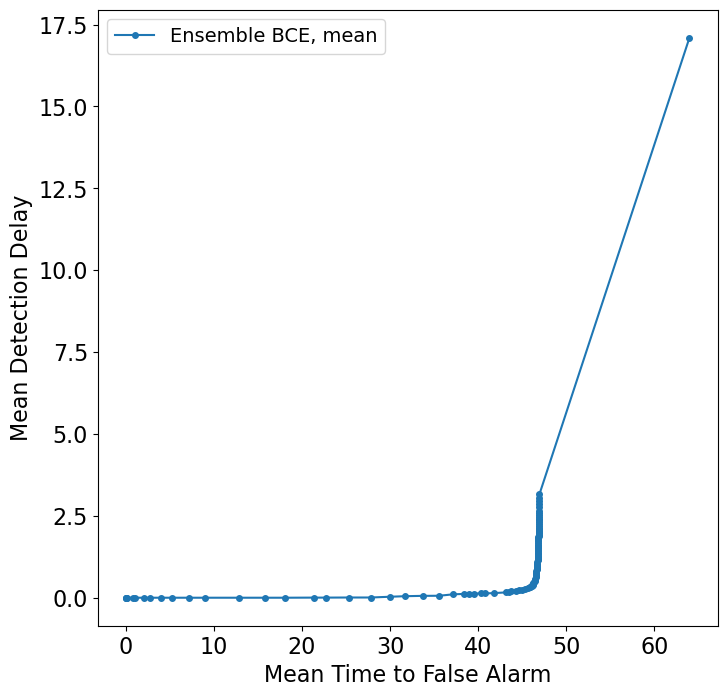

In [10]:
# plot Detection Curve

plt.figure(figsize=(8, 8))
plt.plot(fp_delay_list.values(), delay_list.values(), '-o', markersize=4, label='Ensemble BCE, mean')

plt.xlabel('Mean Time to False Alarm', fontsize=16)
plt.ylabel('Mean Detection Delay', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left', fontsize=14);

## Experiments with quantile-based predictions

In order to obtain not 'mean', but quantile predictions of the ensemble, one only needs pass the corresponding arguments to the 'evaluation_pipeline' function. Note that we use the same (already trained or loaded) Ensemble Model.

In [13]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

# desired probability for a quantile
q = 0.7

# compute metrics
metrics_local, delay_list, fp_delay_list = \
    metrics.evaluation_pipeline(ens_mnist_bce,
                                test_dataloader,
                                threshold_list,
                                device="cuda", # choose 'cpu' or 'cuda' if available
                                model_type="ensemble_quantile",
                                verbose=True,
                                q=q
                                )

  1%|▋                                                                     | 1/102 [00:05<08:45,  5.20s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.7872509765625


  2%|█▎                                                                    | 2/102 [00:10<08:45,  5.25s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.7872509765625


  3%|██                                                                    | 3/102 [00:15<08:42,  5.28s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.7872509765625


  4%|██▋                                                                   | 4/102 [00:20<08:31,  5.22s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.7872509765625


  5%|███▍                                                                  | 5/102 [00:26<08:22,  5.18s/it]

TN: 1, FP: 299, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.30666667222976685, COVER: 0.7881508608217592


  6%|████                                                                  | 6/102 [00:31<08:14,  5.15s/it]

TN: 2, FP: 297, FN: 0, TP: 1, DELAY:0.0, FP_DELAY:0.7733333110809326, COVER: 0.7909994335381054


  7%|████▊                                                                 | 7/102 [00:36<08:07,  5.13s/it]

TN: 4, FP: 295, FN: 0, TP: 1, DELAY:0.0, FP_DELAY:1.2066667079925537, COVER: 0.79115388601354


  8%|█████▍                                                                | 8/102 [00:41<08:00,  5.11s/it]

TN: 7, FP: 292, FN: 0, TP: 1, DELAY:0.0, FP_DELAY:2.009999990463257, COVER: 0.7932014009830695


  9%|██████▏                                                               | 9/102 [00:46<07:53,  5.10s/it]

TN: 8, FP: 289, FN: 0, TP: 3, DELAY:0.0, FP_DELAY:2.4766666889190674, COVER: 0.796419205544471


 10%|██████▊                                                              | 10/102 [00:51<07:54,  5.16s/it]

TN: 14, FP: 283, FN: 0, TP: 3, DELAY:0.0, FP_DELAY:3.9766666889190674, COVER: 0.7987895348916152


 11%|███████▍                                                             | 11/102 [00:56<07:51,  5.18s/it]

TN: 18, FP: 279, FN: 0, TP: 3, DELAY:0.0, FP_DELAY:5.0966668128967285, COVER: 0.7994166338748233


 12%|████████                                                             | 12/102 [01:02<07:45,  5.17s/it]

TN: 26, FP: 271, FN: 0, TP: 3, DELAY:0.0, FP_DELAY:7.2833333015441895, COVER: 0.8049038905075272


 13%|████████▊                                                            | 13/102 [01:07<07:40,  5.18s/it]

TN: 30, FP: 267, FN: 0, TP: 3, DELAY:0.0, FP_DELAY:8.649999618530273, COVER: 0.8130755630968138


 14%|█████████▍                                                           | 14/102 [01:12<07:33,  5.15s/it]

TN: 44, FP: 252, FN: 0, TP: 4, DELAY:0.0, FP_DELAY:12.013333320617676, COVER: 0.8184905269508054


 15%|██████████▏                                                          | 15/102 [01:17<07:37,  5.26s/it]

TN: 57, FP: 236, FN: 0, TP: 7, DELAY:0.0, FP_DELAY:15.743332862854004, COVER: 0.8327763830866217


 16%|██████████▊                                                          | 16/102 [01:23<07:30,  5.24s/it]

TN: 66, FP: 225, FN: 0, TP: 9, DELAY:0.0, FP_DELAY:18.273332595825195, COVER: 0.8399299612945951


 17%|███████████▌                                                         | 17/102 [01:28<07:24,  5.23s/it]

TN: 75, FP: 212, FN: 0, TP: 13, DELAY:0.0033333334140479565, FP_DELAY:20.85333251953125, COVER: 0.8512806339941982


 18%|████████████▏                                                        | 18/102 [01:33<07:18,  5.22s/it]

TN: 80, FP: 204, FN: 0, TP: 16, DELAY:0.006666666828095913, FP_DELAY:22.523332595825195, COVER: 0.8595345258421779


 19%|████████████▊                                                        | 19/102 [01:38<07:10,  5.19s/it]

TN: 90, FP: 192, FN: 0, TP: 18, DELAY:0.006666666828095913, FP_DELAY:25.626667022705078, COVER: 0.8738120909396514


 20%|█████████████▌                                                       | 20/102 [01:43<07:03,  5.17s/it]

TN: 96, FP: 182, FN: 0, TP: 22, DELAY:0.006666666828095913, FP_DELAY:27.44333267211914, COVER: 0.8828711623034955


 21%|██████████████▏                                                      | 21/102 [01:48<07:01,  5.20s/it]

TN: 104, FP: 171, FN: 0, TP: 25, DELAY:0.029999999329447746, FP_DELAY:29.94333267211914, COVER: 0.8958661017379628


 22%|██████████████▉                                                      | 22/102 [01:54<06:57,  5.22s/it]

TN: 107, FP: 164, FN: 0, TP: 29, DELAY:0.04333333298563957, FP_DELAY:31.236665725708008, COVER: 0.9071482092880565


 23%|███████████████▌                                                     | 23/102 [01:59<06:50,  5.19s/it]

TN: 115, FP: 150, FN: 0, TP: 35, DELAY:0.0533333346247673, FP_DELAY:33.426666259765625, COVER: 0.9156401130957098


 24%|████████████████▏                                                    | 24/102 [02:04<06:41,  5.15s/it]

TN: 121, FP: 142, FN: 0, TP: 37, DELAY:0.05666666850447655, FP_DELAY:35.029998779296875, COVER: 0.9203388050007796


 25%|████████████████▉                                                    | 25/102 [02:09<06:36,  5.15s/it]

TN: 129, FP: 130, FN: 0, TP: 41, DELAY:0.10999999940395355, FP_DELAY:37.37333297729492, COVER: 0.927382541184007


 25%|█████████████████▌                                                   | 26/102 [02:14<06:34,  5.19s/it]

TN: 132, FP: 126, FN: 0, TP: 42, DELAY:0.11999999731779099, FP_DELAY:38.220001220703125, COVER: 0.9301797348716271


 26%|██████████████████▎                                                  | 27/102 [02:20<06:29,  5.20s/it]

TN: 135, FP: 119, FN: 0, TP: 46, DELAY:0.11999999731779099, FP_DELAY:39.310001373291016, COVER: 0.936927546267675


 27%|██████████████████▉                                                  | 28/102 [02:25<06:22,  5.17s/it]

TN: 135, FP: 113, FN: 0, TP: 52, DELAY:0.14000000059604645, FP_DELAY:39.54666519165039, COVER: 0.9413419347101902


 28%|███████████████████▌                                                 | 29/102 [02:30<06:16,  5.15s/it]

TN: 136, FP: 111, FN: 0, TP: 53, DELAY:0.15000000596046448, FP_DELAY:39.869998931884766, COVER: 0.9433250412988614


 29%|████████████████████▎                                                | 30/102 [02:35<06:09,  5.14s/it]

TN: 139, FP: 108, FN: 0, TP: 53, DELAY:0.15666666626930237, FP_DELAY:40.650001525878906, COVER: 0.94558126319787


 30%|████████████████████▉                                                | 31/102 [02:40<06:03,  5.12s/it]

TN: 142, FP: 102, FN: 0, TP: 56, DELAY:0.1666666716337204, FP_DELAY:41.4566650390625, COVER: 0.948249010252521


 31%|█████████████████████▋                                               | 32/102 [02:45<06:04,  5.21s/it]

TN: 147, FP: 93, FN: 0, TP: 60, DELAY:0.20333333313465118, FP_DELAY:42.84000015258789, COVER: 0.9522354726414987


 32%|██████████████████████▎                                              | 33/102 [02:51<05:58,  5.20s/it]

TN: 149, FP: 88, FN: 0, TP: 63, DELAY:0.20333333313465118, FP_DELAY:43.40666580200195, COVER: 0.954452903962273


 33%|███████████████████████                                              | 34/102 [02:56<05:53,  5.19s/it]

TN: 150, FP: 85, FN: 0, TP: 65, DELAY:0.22333332896232605, FP_DELAY:43.856666564941406, COVER: 0.957367291058506


 34%|███████████████████████▋                                             | 35/102 [03:01<05:46,  5.18s/it]

TN: 153, FP: 74, FN: 0, TP: 73, DELAY:0.23333333432674408, FP_DELAY:44.41666793823242, COVER: 0.9600540694829108


 35%|████████████████████████▎                                            | 36/102 [03:06<05:43,  5.21s/it]

TN: 154, FP: 69, FN: 0, TP: 77, DELAY:0.23999999463558197, FP_DELAY:44.79999923706055, COVER: 0.9634912895480704


 36%|█████████████████████████                                            | 37/102 [03:11<05:36,  5.18s/it]

TN: 156, FP: 66, FN: 0, TP: 78, DELAY:0.2633333206176758, FP_DELAY:45.25666809082031, COVER: 0.963609482658887


 37%|█████████████████████████▋                                           | 38/102 [03:16<05:29,  5.14s/it]

TN: 156, FP: 65, FN: 0, TP: 79, DELAY:0.28999999165534973, FP_DELAY:45.349998474121094, COVER: 0.9646973908852048


 38%|██████████████████████████▍                                          | 39/102 [03:22<05:25,  5.17s/it]

TN: 156, FP: 64, FN: 0, TP: 80, DELAY:0.30000001192092896, FP_DELAY:45.369998931884766, COVER: 0.9649680667679136


 39%|███████████████████████████                                          | 40/102 [03:27<05:19,  5.15s/it]

TN: 157, FP: 61, FN: 0, TP: 82, DELAY:0.3166666626930237, FP_DELAY:45.84000015258789, COVER: 0.9681819283916188


 40%|███████████████████████████▋                                         | 41/102 [03:32<05:11,  5.11s/it]

TN: 158, FP: 59, FN: 0, TP: 83, DELAY:0.33666667342185974, FP_DELAY:46.086666107177734, COVER: 0.9685400419564598


 41%|████████████████████████████▍                                        | 42/102 [03:37<05:06,  5.11s/it]

TN: 158, FP: 57, FN: 0, TP: 85, DELAY:0.3633333444595337, FP_DELAY:46.11666488647461, COVER: 0.9686453086924136


 42%|█████████████████████████████                                        | 43/102 [03:42<05:00,  5.09s/it]

TN: 158, FP: 57, FN: 0, TP: 85, DELAY:0.3700000047683716, FP_DELAY:46.143333435058594, COVER: 0.9691863710055937


 43%|█████████████████████████████▊                                       | 44/102 [03:47<04:54,  5.08s/it]

TN: 158, FP: 56, FN: 0, TP: 86, DELAY:0.3766666650772095, FP_DELAY:46.16999816894531, COVER: 0.9697168930997982


 44%|██████████████████████████████▍                                      | 45/102 [03:52<04:49,  5.08s/it]

TN: 158, FP: 56, FN: 0, TP: 86, DELAY:0.4000000059604645, FP_DELAY:46.176666259765625, COVER: 0.9692209029249141


 45%|███████████████████████████████                                      | 46/102 [03:57<04:44,  5.08s/it]

TN: 158, FP: 56, FN: 0, TP: 86, DELAY:0.4033333361148834, FP_DELAY:46.18333435058594, COVER: 0.969313020291122


 46%|███████████████████████████████▊                                     | 47/102 [04:02<04:38,  5.07s/it]

TN: 158, FP: 54, FN: 0, TP: 88, DELAY:0.4166666567325592, FP_DELAY:46.21666717529297, COVER: 0.9698480692748651


 47%|████████████████████████████████▍                                    | 48/102 [04:07<04:34,  5.09s/it]

TN: 158, FP: 52, FN: 0, TP: 90, DELAY:0.4300000071525574, FP_DELAY:46.279998779296875, COVER: 0.9712712424394602


 48%|█████████████████████████████████▏                                   | 49/102 [04:12<04:31,  5.13s/it]

TN: 158, FP: 52, FN: 0, TP: 90, DELAY:0.4699999988079071, FP_DELAY:46.40999984741211, COVER: 0.9720717079548977


 49%|█████████████████████████████████▊                                   | 50/102 [04:18<04:26,  5.13s/it]

TN: 158, FP: 52, FN: 0, TP: 90, DELAY:0.47999998927116394, FP_DELAY:46.43000030517578, COVER: 0.972356202774294


 50%|██████████████████████████████████▌                                  | 51/102 [04:23<04:26,  5.22s/it]

TN: 158, FP: 52, FN: 0, TP: 90, DELAY:0.5099999904632568, FP_DELAY:46.439998626708984, COVER: 0.9717821215178317


 51%|███████████████████████████████████▏                                 | 52/102 [04:28<04:19,  5.18s/it]

TN: 158, FP: 51, FN: 0, TP: 91, DELAY:0.5433333516120911, FP_DELAY:46.44333267211914, COVER: 0.9709086276894053


 52%|███████████████████████████████████▊                                 | 53/102 [04:33<04:12,  5.16s/it]

TN: 158, FP: 49, FN: 0, TP: 93, DELAY:0.5566666722297668, FP_DELAY:46.46333312988281, COVER: 0.9710994505623451


 53%|████████████████████████████████████▌                                | 54/102 [04:39<04:13,  5.28s/it]

TN: 158, FP: 47, FN: 0, TP: 95, DELAY:0.5699999928474426, FP_DELAY:46.47999954223633, COVER: 0.9711679671029185


 54%|█████████████████████████████████████▏                               | 55/102 [04:44<04:06,  5.24s/it]

TN: 158, FP: 42, FN: 0, TP: 100, DELAY:0.5899999737739563, FP_DELAY:46.51333236694336, COVER: 0.9716038087964508


 55%|█████████████████████████████████████▉                               | 56/102 [04:49<03:59,  5.21s/it]

TN: 158, FP: 42, FN: 0, TP: 100, DELAY:0.6000000238418579, FP_DELAY:46.526668548583984, COVER: 0.9717014558995974


 56%|██████████████████████████████████████▌                              | 57/102 [04:54<03:53,  5.19s/it]

TN: 158, FP: 39, FN: 0, TP: 103, DELAY:0.6299999952316284, FP_DELAY:46.5433349609375, COVER: 0.9713285034320216


 57%|███████████████████████████████████████▏                             | 58/102 [04:59<03:47,  5.18s/it]

TN: 158, FP: 37, FN: 0, TP: 105, DELAY:0.6499999761581421, FP_DELAY:46.560001373291016, COVER: 0.9712275344350273


 58%|███████████████████████████████████████▉                             | 59/102 [05:04<03:41,  5.16s/it]

TN: 158, FP: 37, FN: 0, TP: 105, DELAY:0.6700000166893005, FP_DELAY:46.56999969482422, COVER: 0.9709196017717374


 59%|████████████████████████████████████████▌                            | 60/102 [05:10<03:38,  5.21s/it]

TN: 158, FP: 36, FN: 0, TP: 106, DELAY:0.6933333277702332, FP_DELAY:46.57666778564453, COVER: 0.9704558178158228


 60%|█████████████████████████████████████████▎                           | 61/102 [05:15<03:31,  5.17s/it]

TN: 158, FP: 35, FN: 0, TP: 107, DELAY:0.70333331823349, FP_DELAY:46.59333419799805, COVER: 0.9706239673732064


 61%|█████████████████████████████████████████▉                           | 62/102 [05:20<03:29,  5.24s/it]

TN: 158, FP: 34, FN: 0, TP: 108, DELAY:0.7366666793823242, FP_DELAY:46.599998474121094, COVER: 0.9698879609620807


 62%|██████████████████████████████████████████▌                          | 63/102 [05:25<03:23,  5.22s/it]

TN: 158, FP: 32, FN: 0, TP: 110, DELAY:0.75, FP_DELAY:46.61000061035156, COVER: 0.9698151451690027


 63%|███████████████████████████████████████████▎                         | 64/102 [05:31<03:17,  5.21s/it]

TN: 158, FP: 31, FN: 0, TP: 111, DELAY:0.7699999809265137, FP_DELAY:46.61666488647461, COVER: 0.9694193455464591


 64%|███████████████████████████████████████████▉                         | 65/102 [05:36<03:13,  5.23s/it]

TN: 158, FP: 30, FN: 0, TP: 112, DELAY:0.79666668176651, FP_DELAY:46.62333297729492, COVER: 0.9688484482139469


 65%|████████████████████████████████████████████▋                        | 66/102 [05:41<03:08,  5.24s/it]

TN: 158, FP: 28, FN: 0, TP: 114, DELAY:0.8199999928474426, FP_DELAY:46.630001068115234, COVER: 0.9683706058889038


 66%|█████████████████████████████████████████████▎                       | 67/102 [05:46<03:01,  5.19s/it]

TN: 158, FP: 27, FN: 0, TP: 115, DELAY:0.8366666436195374, FP_DELAY:46.64666748046875, COVER: 0.9683817830000866


 67%|██████████████████████████████████████████████                       | 68/102 [05:51<02:55,  5.15s/it]

TN: 158, FP: 26, FN: 0, TP: 116, DELAY:0.8600000143051147, FP_DELAY:46.6533317565918, COVER: 0.9679277449167311


 68%|██████████████████████████████████████████████▋                      | 69/102 [05:56<02:49,  5.15s/it]

TN: 158, FP: 25, FN: 0, TP: 117, DELAY:0.8899999856948853, FP_DELAY:46.663333892822266, COVER: 0.9673611112543805


 69%|███████████████████████████████████████████████▎                     | 70/102 [06:02<02:46,  5.21s/it]

TN: 158, FP: 25, FN: 0, TP: 117, DELAY:0.8999999761581421, FP_DELAY:46.66666793823242, COVER: 0.967196105846441


 70%|████████████████████████████████████████████████                     | 71/102 [06:07<02:41,  5.22s/it]

TN: 158, FP: 24, FN: 0, TP: 118, DELAY:0.9200000166893005, FP_DELAY:46.676666259765625, COVER: 0.9669585729860766


 71%|████████████████████████████████████████████████▋                    | 72/102 [06:12<02:35,  5.17s/it]

TN: 158, FP: 24, FN: 0, TP: 118, DELAY:0.95333331823349, FP_DELAY:46.68000030517578, COVER: 0.966114641717833


 72%|█████████████████████████████████████████████████▍                   | 73/102 [06:17<02:29,  5.16s/it]

TN: 158, FP: 24, FN: 0, TP: 118, DELAY:0.9733333587646484, FP_DELAY:46.68000030517578, COVER: 0.9655776529886896


 73%|██████████████████████████████████████████████████                   | 74/102 [06:22<02:23,  5.13s/it]

TN: 158, FP: 22, FN: 0, TP: 120, DELAY:0.9866666793823242, FP_DELAY:46.689998626708984, COVER: 0.9655186319121415


 74%|██████████████████████████████████████████████████▋                  | 75/102 [06:27<02:18,  5.15s/it]

TN: 158, FP: 21, FN: 0, TP: 121, DELAY:1.0133333206176758, FP_DELAY:46.6966667175293, COVER: 0.9649852679742104


 75%|███████████████████████████████████████████████████▍                 | 76/102 [06:33<02:13,  5.14s/it]

TN: 158, FP: 19, FN: 0, TP: 123, DELAY:1.0333333015441895, FP_DELAY:46.71333312988281, COVER: 0.9648852672306971


 75%|████████████████████████████████████████████████████                 | 77/102 [06:38<02:08,  5.13s/it]

TN: 158, FP: 18, FN: 0, TP: 124, DELAY:1.0533332824707031, FP_DELAY:46.72999954223633, COVER: 0.9648572783763685


 76%|████████████████████████████████████████████████████▊                | 78/102 [06:43<02:02,  5.12s/it]

TN: 158, FP: 17, FN: 0, TP: 125, DELAY:1.09333336353302, FP_DELAY:46.73666763305664, COVER: 0.9639352503897666


 77%|█████████████████████████████████████████████████████▍               | 79/102 [06:48<01:58,  5.15s/it]

TN: 158, FP: 17, FN: 0, TP: 125, DELAY:1.1133333444595337, FP_DELAY:46.7400016784668, COVER: 0.9634584687238725


 78%|██████████████████████████████████████████████████████               | 80/102 [06:53<01:53,  5.14s/it]

TN: 158, FP: 17, FN: 0, TP: 125, DELAY:1.153333306312561, FP_DELAY:46.7400016784668, COVER: 0.9623874889282827


 79%|██████████████████████████████████████████████████████▊              | 81/102 [06:58<01:48,  5.16s/it]

TN: 158, FP: 16, FN: 0, TP: 126, DELAY:1.1799999475479126, FP_DELAY:46.74333190917969, COVER: 0.9617381259003446


 80%|███████████████████████████████████████████████████████▍             | 82/102 [07:04<01:43,  5.18s/it]

TN: 158, FP: 15, FN: 0, TP: 127, DELAY:1.2133333683013916, FP_DELAY:46.75, COVER: 0.9609871174640913


 81%|████████████████████████████████████████████████████████▏            | 83/102 [07:09<01:38,  5.18s/it]

TN: 158, FP: 14, FN: 0, TP: 128, DELAY:1.2366666793823242, FP_DELAY:46.753334045410156, COVER: 0.9604082573315302


 82%|████████████████████████████████████████████████████████▊            | 84/102 [07:14<01:34,  5.23s/it]

TN: 158, FP: 14, FN: 0, TP: 128, DELAY:1.2699999809265137, FP_DELAY:46.76333236694336, COVER: 0.9597479372839807


 83%|█████████████████████████████████████████████████████████▌           | 85/102 [07:19<01:29,  5.25s/it]

TN: 158, FP: 13, FN: 0, TP: 129, DELAY:1.2966666221618652, FP_DELAY:46.766666412353516, COVER: 0.9591070288341453


 84%|██████████████████████████████████████████████████████████▏          | 86/102 [07:25<01:23,  5.21s/it]

TN: 158, FP: 12, FN: 0, TP: 130, DELAY:1.3333333730697632, FP_DELAY:46.77000045776367, COVER: 0.9583055685400791


 85%|██████████████████████████████████████████████████████████▊          | 87/102 [07:30<01:17,  5.19s/it]

TN: 158, FP: 12, FN: 0, TP: 130, DELAY:1.3600000143051147, FP_DELAY:46.776668548583984, COVER: 0.9578700737246584


 86%|███████████████████████████████████████████████████████████▌         | 88/102 [07:35<01:12,  5.17s/it]

TN: 158, FP: 12, FN: 0, TP: 130, DELAY:1.3866666555404663, FP_DELAY:46.78333282470703, COVER: 0.9572976070202257


 87%|████████████████████████████████████████████████████████████▏        | 89/102 [07:40<01:06,  5.15s/it]

TN: 158, FP: 11, FN: 0, TP: 131, DELAY:1.4266666173934937, FP_DELAY:46.7933349609375, COVER: 0.9564870070497191


 88%|████████████████████████████████████████████████████████████▉        | 90/102 [07:45<01:02,  5.23s/it]

TN: 158, FP: 10, FN: 0, TP: 132, DELAY:1.4533333778381348, FP_DELAY:46.79999923706055, COVER: 0.9560458508046058


 89%|█████████████████████████████████████████████████████████████▌       | 91/102 [07:51<00:59,  5.39s/it]

TN: 158, FP: 8, FN: 0, TP: 134, DELAY:1.5099999904632568, FP_DELAY:46.80666732788086, COVER: 0.9546157958864812


 90%|██████████████████████████████████████████████████████████████▏      | 92/102 [07:57<00:55,  5.53s/it]

TN: 158, FP: 8, FN: 0, TP: 134, DELAY:1.5700000524520874, FP_DELAY:46.813331604003906, COVER: 0.9531712286959093


 91%|██████████████████████████████████████████████████████████████▉      | 93/102 [08:03<00:50,  5.63s/it]

TN: 158, FP: 7, FN: 0, TP: 135, DELAY:1.6233333349227905, FP_DELAY:46.81999969482422, COVER: 0.9518556281242636


 92%|███████████████████████████████████████████████████████████████▌     | 94/102 [08:08<00:44,  5.55s/it]

TN: 158, FP: 7, FN: 0, TP: 135, DELAY:1.6699999570846558, FP_DELAY:46.823333740234375, COVER: 0.9508097315622418


 93%|████████████████████████████████████████████████████████████████▎    | 95/102 [08:14<00:39,  5.64s/it]

TN: 158, FP: 7, FN: 0, TP: 135, DELAY:1.7300000190734863, FP_DELAY:46.82666778564453, COVER: 0.9492622349087095


 94%|████████████████████████████████████████████████████████████████▉    | 96/102 [08:20<00:33,  5.62s/it]

TN: 158, FP: 7, FN: 0, TP: 135, DELAY:1.7833333015441895, FP_DELAY:46.82666778564453, COVER: 0.9478868471581868


 95%|█████████████████████████████████████████████████████████████████▌   | 97/102 [08:25<00:28,  5.62s/it]

TN: 158, FP: 6, FN: 0, TP: 136, DELAY:1.8833333253860474, FP_DELAY:46.84000015258789, COVER: 0.9456934307907253


 96%|██████████████████████████████████████████████████████████████████▎  | 98/102 [08:31<00:22,  5.56s/it]

TN: 158, FP: 5, FN: 0, TP: 137, DELAY:2.009999990463257, FP_DELAY:46.84333419799805, COVER: 0.9429197199806196


 97%|██████████████████████████████████████████████████████████████████▉  | 99/102 [08:36<00:16,  5.52s/it]

TN: 158, FP: 5, FN: 0, TP: 137, DELAY:2.073333263397217, FP_DELAY:46.8466682434082, COVER: 0.9414598685150586


 98%|██████████████████████████████████████████████████████████████████▋ | 100/102 [08:41<00:10,  5.44s/it]

TN: 158, FP: 4, FN: 0, TP: 138, DELAY:2.180000066757202, FP_DELAY:46.849998474121094, COVER: 0.9390389389147629


 99%|███████████████████████████████████████████████████████████████████▎| 101/102 [08:46<00:05,  5.35s/it]

TN: 158, FP: 4, FN: 0, TP: 138, DELAY:2.2733333110809326, FP_DELAY:46.85333251953125, COVER: 0.9369919484820675


100%|████████████████████████████████████████████████████████████████████| 102/102 [08:52<00:00,  5.22s/it]

TN: 158, FP: 0, FN: 142, TP: 0, DELAY:17.09666633605957, FP_DELAY:64.0, COVER: 0.7872509765625
AUC: 168.7554
Time to FA 46.85, delay detection 2.18 for best-F1 threshold: 0.9926
TN 158, FP 4, FN 0, TP 138 for best-F1 threshold: 0.9926
Max F1 0.9857: for best-F1 threshold 0.9926
COVER 0.939: for best-F1 threshold 0.9926
Max COVER 0.9724: for threshold 0.4622


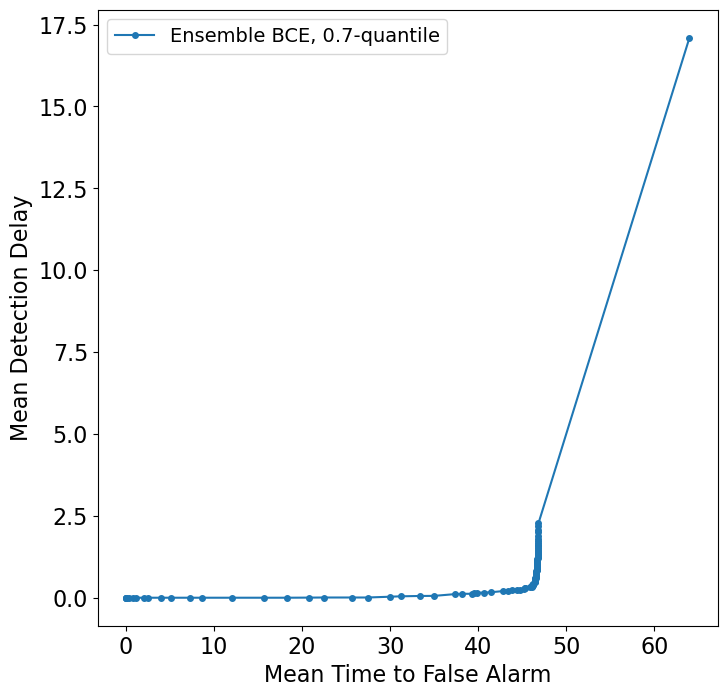

In [14]:
# plot Detection Curve

plt.figure(figsize=(8, 8))
plt.plot(fp_delay_list.values(), delay_list.values(), '-o', markersize=4, label='Ensemble BCE, 0.7-quantile')

plt.xlabel('Mean Time to False Alarm', fontsize=16)
plt.ylabel('Mean Detection Delay', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left', fontsize=14);

## Uncertainty-aware aggregation of CP scores with CUSUM
For this experiments, we have a special 'CusumEnsembleCPDModel' class defined in ensembles.py which has almost the same interface. Note that we do not construct Detection Curves in this experiment.

In [16]:
# choose CUSUM alarm threshold
cusum_threshold = 11.5

# Initialize model and load weights
ens_mnist_bce_susum = CusumEnsembleCPDModel(args_config, n_models=10, cusum_threshold=cusum_threshold)
ens_mnist_bce_susum.load_models_list("saved_models/mnist/full_sample")

# create test_dataset and test_dataloader
test_dataset = ens_mnist_bce_susum.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size = args_config["learning"]["batch_size"])

# no need in threshold list for CUSUM-aggregated CP scores
threshold_list = [0.5]

# compute metrics
metrics_local, delay_list, fp_delay_list = \
    metrics.evaluation_pipeline(ens_mnist_bce_susum,
                                test_dataloader,
                                threshold_list,
                                device="cuda", # choose 'cpu' or 'cuda' if available
                                model_type="cusum_aggr",
                                verbose=True,
                                )

100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.14s/it]

TN: 158, FP: 9, FN: 9, TP: 124, DELAY:2.8299999237060547, FP_DELAY:47.81999969482422, COVER: 0.9340658676516304
AUC: None
Time to FA 47.82, delay detection 2.83 for best-F1 threshold: 0.5
TN 158, FP 9, FN 9, TP 124 for best-F1 threshold: 0.5
Max F1 0.9323: for best-F1 threshold 0.5
COVER 0.9341: for best-F1 threshold 0.5
Max COVER 0.9341: for threshold 0.5


## CPD with rejection
For this experiment, we use the basic EnsembleCPDModel class as well.

In [18]:
# Initialize Ensemble of n_models=10 base models and load weights
ens_mnist_bce = EnsembleCPDModel(args_config, n_models=10)
ens_mnist_bce.load_models_list("saved_models/mnist/full_sample")

In [20]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

# choose std rejection threshold and provide evaluation_pipeline with this argument
uncert_th = 0.03

# compute metrics
metrics_local, delay_list, fp_delay_list = \
    metrics.evaluation_pipeline(ens_mnist_bce,
                                test_dataloader,
                                threshold_list,
                                device="cuda", # choose 'cpu' or 'cuda' if available
                                model_type="ensemble",
                                verbose=True,
                                uncert_th=uncert_th
                                )

  1%|▋                                                                     | 1/102 [00:05<09:08,  5.43s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.07333333045244217, COVER: 0.7867266091696535


  2%|█▎                                                                    | 2/102 [00:10<08:48,  5.29s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.07333333045244217, COVER: 0.7867266091696535


  3%|██                                                                    | 3/102 [00:15<08:44,  5.29s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.07333333045244217, COVER: 0.7867266091696535


  4%|██▋                                                                   | 4/102 [00:21<08:34,  5.25s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.1666666716337204, COVER: 0.7876264934289128


  5%|███▍                                                                  | 5/102 [00:26<08:27,  5.24s/it]

TN: 2, FP: 297, FN: 0, TP: 1, DELAY:0.006666666828095913, FP_DELAY:0.8500000238418579, COVER: 0.7903592363731792


  6%|████                                                                  | 6/102 [00:31<08:27,  5.29s/it]

TN: 3, FP: 296, FN: 0, TP: 1, DELAY:0.006666666828095913, FP_DELAY:1.0666667222976685, COVER: 0.790429198107873


  7%|████▊                                                                 | 7/102 [00:36<08:22,  5.29s/it]

TN: 8, FP: 291, FN: 0, TP: 1, DELAY:0.006666666828095913, FP_DELAY:2.183333396911621, COVER: 0.7913672295704581


  8%|█████▍                                                                | 8/102 [00:42<08:22,  5.34s/it]

TN: 9, FP: 288, FN: 0, TP: 3, DELAY:0.01666666753590107, FP_DELAY:2.7766666412353516, COVER: 0.7956482596848182


  9%|██████▏                                                               | 9/102 [00:47<08:16,  5.34s/it]

TN: 14, FP: 281, FN: 0, TP: 5, DELAY:0.03333333507180214, FP_DELAY:4.139999866485596, COVER: 0.7985332391223263


 10%|██████▊                                                              | 10/102 [00:53<08:13,  5.37s/it]

TN: 18, FP: 277, FN: 0, TP: 5, DELAY:0.03333333507180214, FP_DELAY:5.296666622161865, COVER: 0.7986403066889364


 11%|███████▍                                                             | 11/102 [00:58<08:14,  5.44s/it]

TN: 25, FP: 268, FN: 0, TP: 7, DELAY:0.05999999865889549, FP_DELAY:7.253333568572998, COVER: 0.8045255656832918


 12%|████████                                                             | 12/102 [01:04<08:08,  5.42s/it]

TN: 32, FP: 257, FN: 0, TP: 11, DELAY:0.0833333358168602, FP_DELAY:9.306666374206543, COVER: 0.8129566505566245


 13%|████████▊                                                            | 13/102 [01:09<08:01,  5.41s/it]

TN: 46, FP: 238, FN: 0, TP: 16, DELAY:0.12666666507720947, FP_DELAY:13.16333293914795, COVER: 0.8255703248692596


 14%|█████████▍                                                           | 14/102 [01:14<07:50,  5.35s/it]

TN: 59, FP: 219, FN: 0, TP: 22, DELAY:0.2199999988079071, FP_DELAY:16.503334045410156, COVER: 0.8337490310125708


 15%|██████████▏                                                          | 15/102 [01:20<07:43,  5.33s/it]

TN: 69, FP: 200, FN: 0, TP: 31, DELAY:0.3566666543483734, FP_DELAY:19.329999923706055, COVER: 0.8447683077069927


 16%|██████████▊                                                          | 16/102 [01:25<07:40,  5.35s/it]

TN: 80, FP: 179, FN: 0, TP: 41, DELAY:0.4300000071525574, FP_DELAY:22.6733341217041, COVER: 0.8583790881858202


 17%|███████████▌                                                         | 17/102 [01:30<07:37,  5.38s/it]

TN: 83, FP: 168, FN: 0, TP: 49, DELAY:0.5633333325386047, FP_DELAY:24.1733341217041, COVER: 0.8679731568563069


 18%|████████████▏                                                        | 18/102 [01:36<07:28,  5.34s/it]

TN: 93, FP: 150, FN: 0, TP: 57, DELAY:0.6700000166893005, FP_DELAY:26.933332443237305, COVER: 0.8769822179281986


 19%|████████████▊                                                        | 19/102 [01:41<07:23,  5.34s/it]

TN: 101, FP: 124, FN: 0, TP: 75, DELAY:0.9233333468437195, FP_DELAY:29.933332443237305, COVER: 0.8930176297177632


 20%|█████████████▌                                                       | 20/102 [01:46<07:15,  5.31s/it]

TN: 107, FP: 101, FN: 0, TP: 92, DELAY:1.2266666889190674, FP_DELAY:32.52000045776367, COVER: 0.9089437930970647


 21%|██████████████▏                                                      | 21/102 [01:52<07:12,  5.33s/it]

TN: 113, FP: 86, FN: 0, TP: 101, DELAY:1.4700000286102295, FP_DELAY:34.266666412353516, COVER: 0.9122353330179813


 22%|██████████████▉                                                      | 22/102 [01:57<07:10,  5.39s/it]

TN: 120, FP: 68, FN: 0, TP: 112, DELAY:1.6766666173934937, FP_DELAY:36.29666519165039, COVER: 0.9157917733027481


 23%|███████████████▌                                                     | 23/102 [02:03<07:06,  5.40s/it]

TN: 126, FP: 54, FN: 0, TP: 120, DELAY:1.7766666412353516, FP_DELAY:38.233333587646484, COVER: 0.9225996493264285


 24%|████████████████▏                                                    | 24/102 [02:08<07:01,  5.40s/it]

TN: 133, FP: 44, FN: 1, TP: 122, DELAY:1.8733333349227905, FP_DELAY:40.186668395996094, COVER: 0.9249741841873763


 25%|████████████████▉                                                    | 25/102 [02:13<06:53,  5.37s/it]

TN: 140, FP: 34, FN: 1, TP: 125, DELAY:1.9366666078567505, FP_DELAY:41.91666793823242, COVER: 0.927664481890302


 25%|█████████████████▌                                                   | 26/102 [02:19<06:47,  5.36s/it]

TN: 142, FP: 30, FN: 1, TP: 127, DELAY:1.9633333683013916, FP_DELAY:42.45000076293945, COVER: 0.9286677063861434


 26%|██████████████████▎                                                  | 27/102 [02:25<06:53,  5.51s/it]

TN: 143, FP: 26, FN: 1, TP: 130, DELAY:2.066666603088379, FP_DELAY:42.970001220703125, COVER: 0.9306558113702393


 27%|██████████████████▉                                                  | 28/102 [02:30<06:47,  5.51s/it]

TN: 145, FP: 21, FN: 1, TP: 133, DELAY:2.109999895095825, FP_DELAY:43.663333892822266, COVER: 0.9341801949652723


 28%|███████████████████▌                                                 | 29/102 [02:35<06:39,  5.47s/it]

TN: 147, FP: 19, FN: 1, TP: 133, DELAY:2.109999895095825, FP_DELAY:44.086666107177734, COVER: 0.9342322782986056


 29%|████████████████████▎                                                | 30/102 [02:41<06:38,  5.54s/it]

TN: 150, FP: 16, FN: 1, TP: 133, DELAY:2.109999895095825, FP_DELAY:44.83333206176758, COVER: 0.9355864449652722


 30%|████████████████████▉                                                | 31/102 [02:46<06:30,  5.49s/it]

TN: 155, FP: 9, FN: 1, TP: 135, DELAY:2.180000066757202, FP_DELAY:46.11333465576172, COVER: 0.9365340556506703
TN: 155, FP: 8, FN: 1, TP: 136, DELAY:2.190000057220459, FP_DELAY:46.233333587646484, COVER: 0.9378741998814394


 32%|██████████████████████▎                                              | 33/102 [02:59<06:40,  5.80s/it]

TN: 156, FP: 7, FN: 1, TP: 136, DELAY:2.190000057220459, FP_DELAY:46.4466667175293, COVER: 0.9378741998814394


 33%|███████████████████████                                              | 34/102 [03:05<06:45,  5.96s/it]

TN: 158, FP: 5, FN: 1, TP: 136, DELAY:2.190000057220459, FP_DELAY:46.87333297729492, COVER: 0.9378741998814394


 34%|███████████████████████▋                                             | 35/102 [03:10<06:26,  5.77s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 35%|████████████████████████▎                                            | 36/102 [03:16<06:18,  5.73s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 36%|█████████████████████████                                            | 37/102 [03:21<06:01,  5.57s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 37%|█████████████████████████▋                                           | 38/102 [03:28<06:13,  5.84s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 38%|██████████████████████████▍                                          | 39/102 [03:33<06:04,  5.78s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 39%|███████████████████████████                                          | 40/102 [03:40<06:20,  6.13s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 40%|███████████████████████████▋                                         | 41/102 [03:46<06:00,  5.92s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 41%|████████████████████████████▍                                        | 42/102 [03:52<06:00,  6.01s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 42%|█████████████████████████████                                        | 43/102 [03:57<05:37,  5.72s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 43%|█████████████████████████████▊                                       | 44/102 [04:03<05:34,  5.76s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 44%|██████████████████████████████▍                                      | 45/102 [04:08<05:19,  5.60s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 45%|███████████████████████████████                                      | 46/102 [04:14<05:11,  5.57s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 46%|███████████████████████████████▊                                     | 47/102 [04:19<04:59,  5.44s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 47%|████████████████████████████████▍                                    | 48/102 [04:24<04:48,  5.34s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 48%|█████████████████████████████████▏                                   | 49/102 [04:29<04:39,  5.28s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 49%|█████████████████████████████████▊                                   | 50/102 [04:34<04:31,  5.23s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 50%|██████████████████████████████████▌                                  | 51/102 [04:39<04:26,  5.22s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 51%|███████████████████████████████████▏                                 | 52/102 [04:44<04:19,  5.20s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 52%|███████████████████████████████████▊                                 | 53/102 [04:50<04:13,  5.18s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 53%|████████████████████████████████████▌                                | 54/102 [04:55<04:16,  5.35s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 54%|█████████████████████████████████████▏                               | 55/102 [05:01<04:09,  5.31s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 55%|█████████████████████████████████████▉                               | 56/102 [05:06<04:01,  5.25s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 56%|██████████████████████████████████████▌                              | 57/102 [05:11<03:56,  5.25s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 57%|███████████████████████████████████████▏                             | 58/102 [05:16<03:49,  5.21s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 58%|███████████████████████████████████████▉                             | 59/102 [05:21<03:44,  5.22s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 59%|████████████████████████████████████████▌                            | 60/102 [05:27<03:41,  5.27s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 60%|█████████████████████████████████████████▎                           | 61/102 [05:32<03:37,  5.30s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 61%|█████████████████████████████████████████▉                           | 62/102 [05:37<03:30,  5.26s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 62%|██████████████████████████████████████████▌                          | 63/102 [05:42<03:24,  5.25s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 63%|███████████████████████████████████████████▎                         | 64/102 [05:48<03:18,  5.22s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 64%|███████████████████████████████████████████▉                         | 65/102 [05:53<03:13,  5.22s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 65%|████████████████████████████████████████████▋                        | 66/102 [05:58<03:09,  5.27s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 66%|█████████████████████████████████████████████▎                       | 67/102 [06:03<03:04,  5.26s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 67%|██████████████████████████████████████████████                       | 68/102 [06:09<02:59,  5.27s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 68%|██████████████████████████████████████████████▋                      | 69/102 [06:14<02:52,  5.24s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 69%|███████████████████████████████████████████████▎                     | 70/102 [06:19<02:49,  5.28s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 70%|████████████████████████████████████████████████                     | 71/102 [06:24<02:42,  5.23s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 71%|████████████████████████████████████████████████▋                    | 72/102 [06:30<02:36,  5.22s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 72%|█████████████████████████████████████████████████▍                   | 73/102 [06:35<02:31,  5.23s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.193333387374878, FP_DELAY:46.936668395996094, COVER: 0.9391642389439395


 73%|██████████████████████████████████████████████████                   | 74/102 [06:40<02:27,  5.27s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.196666717529297, FP_DELAY:46.936668395996094, COVER: 0.9390624397015154


 74%|██████████████████████████████████████████████████▋                  | 75/102 [06:45<02:21,  5.24s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.196666717529297, FP_DELAY:46.936668395996094, COVER: 0.9390624397015154


 75%|███████████████████████████████████████████████████▍                 | 76/102 [06:52<02:24,  5.57s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.200000047683716, FP_DELAY:46.936668395996094, COVER: 0.938967533940491


 75%|████████████████████████████████████████████████████                 | 77/102 [06:58<02:21,  5.65s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.200000047683716, FP_DELAY:46.936668395996094, COVER: 0.938967533940491


 76%|████████████████████████████████████████████████████▊                | 78/102 [07:04<02:19,  5.83s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.200000047683716, FP_DELAY:46.936668395996094, COVER: 0.938967533940491


 77%|█████████████████████████████████████████████████████▍               | 79/102 [07:09<02:11,  5.72s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.200000047683716, FP_DELAY:46.936668395996094, COVER: 0.938967533940491


 78%|██████████████████████████████████████████████████████               | 80/102 [07:15<02:08,  5.83s/it]

TN: 158, FP: 4, FN: 1, TP: 137, DELAY:2.200000047683716, FP_DELAY:46.936668395996094, COVER: 0.938967533940491


 79%|██████████████████████████████████████████████████████▊              | 81/102 [07:21<02:04,  5.91s/it]

TN: 158, FP: 3, FN: 1, TP: 138, DELAY:2.2033333778381348, FP_DELAY:46.939998626708984, COVER: 0.9389715874042861


 80%|███████████████████████████████████████████████████████▍             | 82/102 [07:28<01:59,  5.98s/it]

TN: 158, FP: 3, FN: 1, TP: 138, DELAY:2.2066667079925537, FP_DELAY:46.939998626708984, COVER: 0.9388819734336978


 81%|████████████████████████████████████████████████████████▏            | 83/102 [07:33<01:51,  5.85s/it]

TN: 158, FP: 3, FN: 1, TP: 138, DELAY:2.2133333683013916, FP_DELAY:46.939998626708984, COVER: 0.9386990565242186


 82%|████████████████████████████████████████████████████████▊            | 84/102 [07:39<01:46,  5.94s/it]

TN: 158, FP: 3, FN: 1, TP: 138, DELAY:2.2166666984558105, FP_DELAY:46.939998626708984, COVER: 0.9386112589051708


 83%|█████████████████████████████████████████████████████████▌           | 85/102 [07:45<01:39,  5.83s/it]

TN: 158, FP: 3, FN: 1, TP: 138, DELAY:2.2233333587646484, FP_DELAY:46.939998626708984, COVER: 0.9384117739028367


 84%|██████████████████████████████████████████████████████████▏          | 86/102 [07:50<01:31,  5.72s/it]

TN: 158, FP: 3, FN: 1, TP: 138, DELAY:2.2300000190734863, FP_DELAY:46.939998626708984, COVER: 0.9382196940762996


 85%|██████████████████████████████████████████████████████████▊          | 87/102 [07:56<01:24,  5.66s/it]

TN: 158, FP: 3, FN: 1, TP: 138, DELAY:2.256666660308838, FP_DELAY:46.939998626708984, COVER: 0.937476653024645


 86%|███████████████████████████████████████████████████████████▌         | 88/102 [08:01<01:18,  5.62s/it]

TN: 158, FP: 3, FN: 1, TP: 138, DELAY:2.2866666316986084, FP_DELAY:46.939998626708984, COVER: 0.9366265875315559


 87%|████████████████████████████████████████████████████████████▏        | 89/102 [08:07<01:13,  5.64s/it]

TN: 158, FP: 3, FN: 1, TP: 138, DELAY:2.319999933242798, FP_DELAY:46.939998626708984, COVER: 0.9357738162803423


 88%|████████████████████████████████████████████████████████████▉        | 90/102 [08:13<01:09,  5.77s/it]

TN: 158, FP: 3, FN: 1, TP: 138, DELAY:2.3566665649414062, FP_DELAY:46.939998626708984, COVER: 0.9348052629042165


 89%|█████████████████████████████████████████████████████████████▌       | 91/102 [08:19<01:02,  5.67s/it]

TN: 158, FP: 3, FN: 1, TP: 138, DELAY:2.390000104904175, FP_DELAY:46.939998626708984, COVER: 0.9339197175217784


 90%|██████████████████████████████████████████████████████████████▏      | 92/102 [08:24<00:56,  5.66s/it]

TN: 158, FP: 3, FN: 1, TP: 138, DELAY:2.426666736602783, FP_DELAY:46.939998626708984, COVER: 0.932949189828172


 91%|██████████████████████████████████████████████████████████████▉      | 93/102 [08:30<00:51,  5.70s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:2.4666666984558105, FP_DELAY:46.94333267211914, COVER: 0.9319861251893453


 92%|███████████████████████████████████████████████████████████████▌     | 94/102 [08:36<00:45,  5.70s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:2.5233333110809326, FP_DELAY:46.94333267211914, COVER: 0.9305951382916352


 93%|████████████████████████████████████████████████████████████████▎    | 95/102 [08:42<00:40,  5.76s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:2.573333263397217, FP_DELAY:46.9466667175293, COVER: 0.9294679019264414


 94%|████████████████████████████████████████████████████████████████▉    | 96/102 [08:47<00:34,  5.79s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:2.6466667652130127, FP_DELAY:46.9466667175293, COVER: 0.9275416429809089


 95%|█████████████████████████████████████████████████████████████████▌   | 97/102 [08:53<00:28,  5.71s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:2.7733333110809326, FP_DELAY:46.95000076293945, COVER: 0.9247847175000159


 96%|██████████████████████████████████████████████████████████████████▎  | 98/102 [08:59<00:23,  5.77s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:2.8566665649414062, FP_DELAY:46.95000076293945, COVER: 0.9229340894593918


 97%|██████████████████████████████████████████████████████████████████▉  | 99/102 [09:05<00:17,  5.82s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:2.9666666984558105, FP_DELAY:46.95000076293945, COVER: 0.9203334970445801


 98%|██████████████████████████████████████████████████████████████████▋ | 100/102 [09:10<00:11,  5.69s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:3.049999952316284, FP_DELAY:46.95000076293945, COVER: 0.9184376896600907


 99%|███████████████████████████████████████████████████████████████████▎| 101/102 [09:16<00:05,  5.72s/it]

TN: 158, FP: 2, FN: 1, TP: 139, DELAY:3.1533334255218506, FP_DELAY:46.9566650390625, COVER: 0.9164264407604924


100%|████████████████████████████████████████████████████████████████████| 102/102 [09:22<00:00,  5.51s/it]

TN: 158, FP: 0, FN: 142, TP: 0, DELAY:17.09666633605957, FP_DELAY:64.0, COVER: 0.7872509765625
AUC: 209.9843
Time to FA 46.9433, delay detection 2.4667 for best-F1 threshold: 0.9851
TN 158, FP 2, FN 1, TP 139 for best-F1 threshold: 0.9851
Max F1 0.9893: for best-F1 threshold 0.9851
COVER 0.932: for best-F1 threshold 0.9851
Max COVER 0.9392: for threshold 0.1589
